In [1]:
from __future__ import absolute_import, division, print_function

import pathlib

import numpy as np
import pandas as pd
import seaborn as sns

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

print (tf.__version__)

1.12.0


In [2]:
#column_names = ['/render/frame time/rendering/microseconds','ar_GI_diffuse_depth','ar_AA_samples','ar_GI_specular_samples','ar_GI_transmission_samples',
#                'ar_GI_diffuse_samples', 'ar_GI_specular_depth', 'ar_bucket_size', "res_overridex", "res_overridey"]

column_names = ['/render/frame time/rendering/microseconds','ar_GI_diffuse_depth','ar_AA_samples',
                'ar_GI_specular_samples', 'ar_GI_diffuse_samples', "res_overridex", "res_overridey"]


raw_dataset = pd.read_csv("../datasets/dataset_a.csv", usecols=column_names, sep=",", skipinitialspace=True)

dataset = raw_dataset.copy()

dataset = dataset.astype("float64")

dataset.tail()


,ar_GI_specular_samples,/render/frame time/rendering/microseconds,ar_AA_samples,res_overridey,res_overridex,ar_GI_diffuse_depth,ar_GI_diffuse_samples
983,6.0,2.889439e+08,4.0,8192.0,4096.0,9.0,2.0
984,2.0,7.004720e+07,6.0,1024.0,1024.0,8.0,3.0
985,2.0,6.282489e+06,3.0,1080.0,256.0,10.0,8.0
986,1.0,1.118134e+08,4.0,4096.0,1024.0,10.0,4.0
987,9.0,1.675580e+09,6.0,1080.0,8192.0,9.0,5.0


In [3]:
dataset.isna().sum()

ar_GI_specular_samples                       0
/render/frame time/rendering/microseconds    0
ar_AA_samples                                0
res_overridey                                0
res_overridex                                0
ar_GI_diffuse_depth                          0
ar_GI_diffuse_samples                        0
dtype: int64

In [4]:
dataset["ar_AA_samples"] = dataset["ar_AA_samples"]**2
dataset["ar_GI_diffuse_samples"] = dataset["ar_GI_diffuse_samples"]**2
dataset["ar_GI_specular_samples"] = dataset["ar_GI_specular_samples"]**2
dataset["pixels"] = dataset["res_overridey"] * dataset["res_overridex"]
dataset["render_seconds"] = dataset["/render/frame time/rendering/microseconds"]/(10**6)

dataset = dataset.drop(columns=["res_overridey", "res_overridex", "/render/frame time/rendering/microseconds"])

dataset.tail()

,ar_GI_specular_samples,ar_AA_samples,ar_GI_diffuse_depth,ar_GI_diffuse_samples,pixels,render_seconds
983,36.0,16.0,9.0,4.0,33554432.0,288.943908
984,4.0,36.0,8.0,9.0,1048576.0,70.047195
985,4.0,9.0,10.0,64.0,276480.0,6.282489
986,1.0,16.0,10.0,16.0,4194304.0,111.813418
987,81.0,36.0,9.0,25.0,8847360.0,1675.580110


In [5]:
#dataset = dataset[dataset['render_seconds'] < 500.0]

#dataset.tail()

In [6]:
dataset["render_seconds"] = np.log(dataset["render_seconds"])

dataset.tail()

,ar_GI_specular_samples,ar_AA_samples,ar_GI_diffuse_depth,ar_GI_diffuse_samples,pixels,render_seconds
983,36.0,16.0,9.0,4.0,33554432.0,5.666233
984,4.0,36.0,8.0,9.0,1048576.0,4.249169
985,4.0,9.0,10.0,64.0,276480.0,1.837766
986,1.0,16.0,10.0,16.0,4194304.0,4.716832
987,81.0,36.0,9.0,25.0,8847360.0,7.423915


In [7]:
train_dataset = dataset.sample(frac=0.8,random_state=0)
test_dataset = dataset.drop(train_dataset.index)

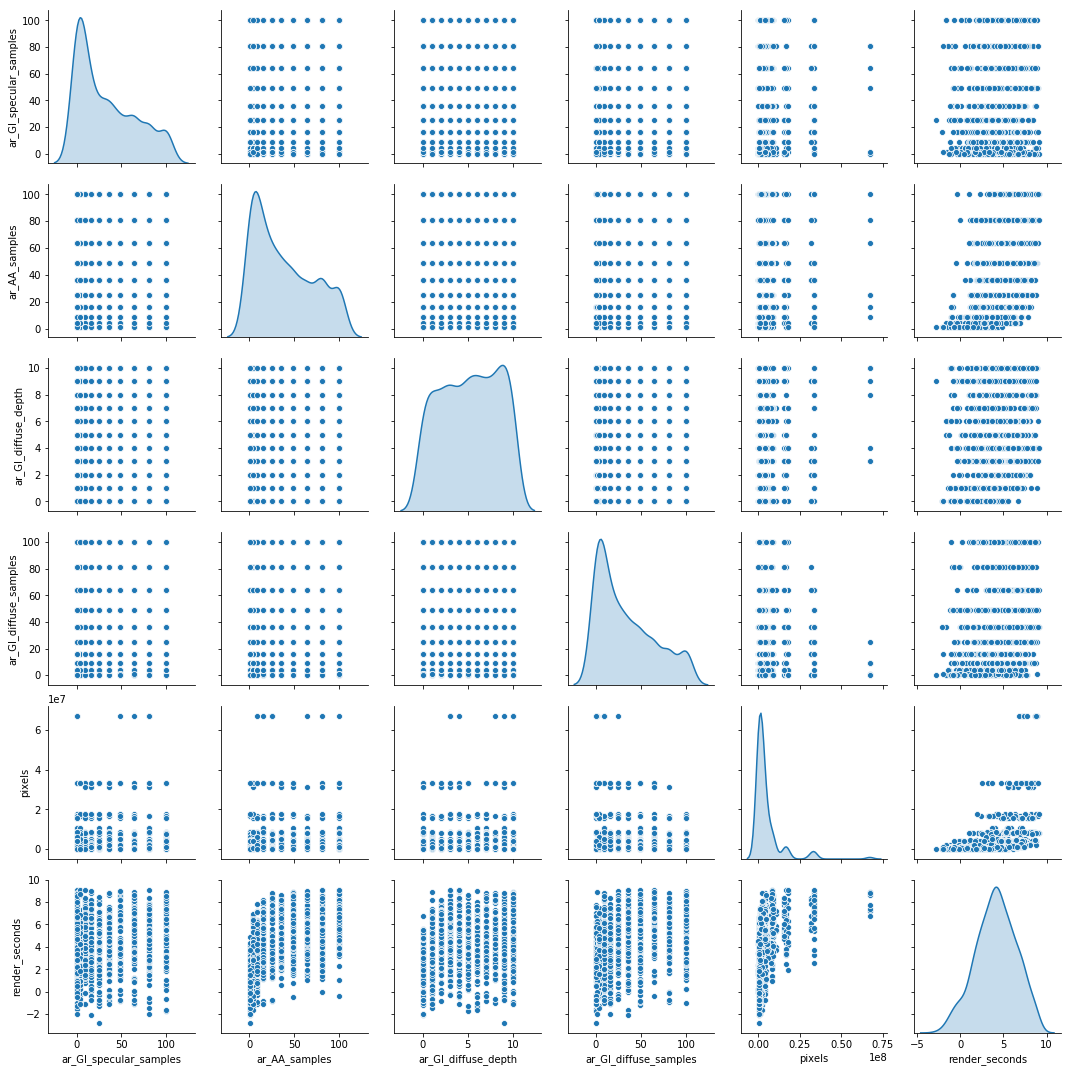

In [8]:
sns.pairplot(dataset[list(dataset)], diag_kind="kde")

In [9]:
train_stats = train_dataset.describe()
train_stats.pop("render_seconds")
train_stats = train_stats.transpose()
train_stats

,count,mean,std,min,25%,50%,75%,max
ar_GI_specular_samples,790.0,3.373418e+01,3.211383e+01,0.0,4.0,25.0,64.0,100.0
ar_AA_samples,790.0,3.945823e+01,3.300682e+01,1.0,9.0,36.0,64.0,100.0
ar_GI_diffuse_depth,790.0,5.263291e+00,3.176521e+00,0.0,3.0,5.0,8.0,10.0
ar_GI_diffuse_samples,790.0,3.278354e+01,3.080718e+01,0.0,4.0,25.0,49.0,100.0
pixels,790.0,4.645600e+06,8.062604e+06,65536.0,614400.0,1966080.0,4194304.0,67108864.0


In [10]:
dataset.describe()

,ar_GI_specular_samples,ar_AA_samples,ar_GI_diffuse_depth,ar_GI_diffuse_samples,pixels,render_seconds
count,988.000000,988.000000,988.000000,988.000000,9.880000e+02,988.000000
mean,33.811741,39.110324,5.226721,33.769231,4.858692e+06,4.165656
std,32.432972,32.609615,3.177175,31.496150,8.709797e+06,2.337820
min,0.000000,1.000000,0.000000,0.000000,6.553600e+04,-2.792449
25%,4.000000,9.000000,3.000000,4.000000,6.144000e+05,2.596505
50%,25.000000,36.000000,5.000000,25.000000,1.966080e+06,4.221717
75%,64.000000,64.000000,8.000000,49.000000,4.194304e+06,5.788413
max,100.000000,100.000000,10.000000,100.000000,6.710886e+07,9.101529


In [11]:
train_labels = train_dataset.pop("render_seconds")
test_labels = test_dataset.pop("render_seconds")

def norm(x):
  return (x - train_stats['mean']) / train_stats['std']

normed_train_data = norm(train_dataset)
normed_test_data = norm(test_dataset)

normed_train_data.tail()

,ar_GI_specular_samples,ar_AA_samples,ar_GI_diffuse_depth,ar_GI_diffuse_samples,pixels
464,-0.770203,-0.922786,1.176353,1.565104,-0.055974
25,2.063467,1.258582,0.861543,-0.934313,-0.055974
110,0.942454,-0.710709,0.861543,-0.934313,-0.494907
149,-0.925899,0.743536,-1.342126,-0.934313,-0.559934
152,-0.925899,-0.922786,1.491162,0.526386,-0.494907


In [12]:
def build_model():
  model = keras.Sequential([
    tf.keras.layers.Dense(64, activation=tf.nn.relu, input_shape=[len(train_dataset.keys())]),
    tf.keras.layers.Dense(64, activation=tf.nn.relu),
    tf.keras.layers.Dense(1)
  ])

  optimizer = tf.keras.optimizers.RMSprop(0.001)

  model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse'])
  return model

model = build_model()
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 64)                384       
_________________________________________________________________
dense_1 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 65        
Total params: 4,609
Trainable params: 4,609
Non-trainable params: 0
_________________________________________________________________


In [13]:
example_batch = normed_train_data[:10]
example_batch
example_result = model.predict(example_batch)
example_result

array([[-0.11097174],
       [-0.22109203],
       [-0.04997541],
       [-0.18155575],
       [-0.16199878],
       [-0.3237107 ],
       [-0.40790552],
       [-0.55811024],
       [-0.270452  ],
       [-0.15110502]], dtype=float32)

In [14]:
# Display training progress by printing a single dot for each completed epoch
class PrintDot(keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs):
    if epoch % 100 == 0: print('')
    print('.', end='')

EPOCHS = 1000

early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=20)

history = model.fit(
  normed_train_data, train_labels,
  epochs=EPOCHS, validation_split = 0.2, verbose=0,
  callbacks=[early_stop, PrintDot()])


...............................................................................

In [15]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

,loss,mean_absolute_error,mean_squared_error,val_loss,val_mean_absolute_error,val_mean_squared_error,epoch
74,0.983153,0.785674,0.983153,1.884777,1.060437,1.884777,74
75,0.964922,0.780520,0.964922,1.946868,1.070729,1.946868,75
76,0.988174,0.788958,0.988174,1.784855,1.040831,1.784855,76
77,0.950948,0.771361,0.950948,1.807624,1.058990,1.807624,77
78,0.979734,0.782193,0.979734,1.999954,1.067658,1.999954,78


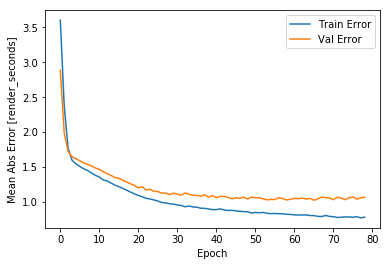

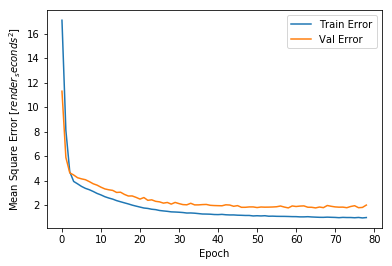

In [16]:
import matplotlib.pyplot as plt

def plot_history(history):
  
  hist = pd.DataFrame(history.history)

  hist['epoch'] = history.epoch
  
  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Mean Abs Error [render_seconds]')
  plt.plot(hist['epoch'], hist['mean_absolute_error'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_mean_absolute_error'],
           label = 'Val Error')
  plt.legend()
  #plt.ylim([0,5])

  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Mean Square Error [$render_seconds^2$]')
  plt.plot(hist['epoch'], hist['mean_squared_error'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_mean_squared_error'],
           label = 'Val Error')
  plt.legend()
  #plt.ylim([0,20])
    
plot_history(history)

In [17]:
loss, mae, mse = model.evaluate(normed_test_data, test_labels, verbose=0)

print("Testing set Mean Abs Error: {:5.2f} seconds".format(  np.exp(mae)  ))

Testing set Mean Abs Error:  2.40 seconds


(-1.4625369113147955,
 11.254287865066786,
 -1.078251752481029,
 11.638573023900554)

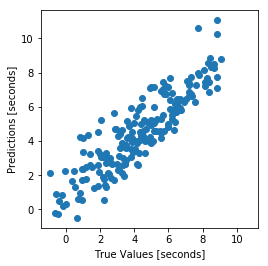

In [18]:
test_predictions = model.predict(normed_test_data).flatten()

plt.scatter(test_labels, test_predictions)
plt.xlabel('True Values [seconds]')
plt.ylabel('Predictions [seconds]')
plt.axis('equal')
plt.axis('square')
#plt.xlim([0,plt.xlim()[1]])
#plt.ylim([0,plt.ylim()[1]])
#_ = plt.plot([-100, 100], [-100, 100])


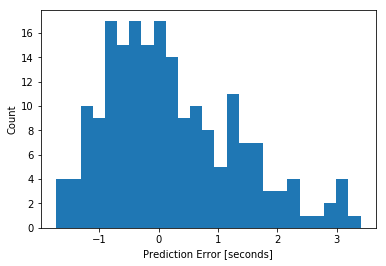

In [19]:
error = test_predictions - test_labels
plt.hist(error, bins = 25)
plt.xlabel("Prediction Error [seconds]")
_ = plt.ylabel("Count")
